The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class

Data Source: https://www.cs.toronto.edu/~kriz/cifar.html

In [4]:
#Path for file
CIFAR_DIR = './cifar-10-batches-py/'

In [8]:
def unpickle(file):
    import pickle
    with open(file,'rb') as f:
        cifar_dict = pickle.load(f)
    return cifar_dict

In [9]:
dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

In [11]:
all_data = [0,1,2,3,4,5,6]

In [12]:
for i,direc in zip(all_data,dirs):
    all_data[i] = unpickle(CIFAR_DIR+direc)

In [13]:
batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]

In [15]:
batch_meta

{'label_names': ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 'num_cases_per_batch': 10000,
 'num_vis': 3072}

In [16]:
data_batch1.keys()

['data', 'labels', 'batch_label', 'filenames']

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [19]:
X = data_batch1['data']

In [20]:
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")

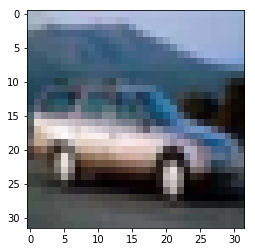

In [22]:
plt.imshow(X[4])

In [23]:
def one_hot_encode(vec, vals=10):
    '''
    For use to one-hot encode the 10- possible labels
    '''
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

In [24]:
class CifarHelper():
    
    def __init__(self):
        self.i = 0
        
        # Grabs a list of all the data batches for training
        self.all_train_batches = [data_batch1,data_batch2,data_batch3,data_batch4,data_batch5]
        # Grabs a list of all the test batches (really just one batch)
        self.test_batch = [test_batch]
        
        # Intialize some empty variables for later on
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")
        
        # Vertically stacks the training images
        self.training_images = np.vstack([d[b"data"] for d in self.all_train_batches])
        train_len = len(self.training_images)
        
        # Reshapes and normalizes training images
        self.training_images = self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        # One hot Encodes the training labels (e.g. [0,0,0,1,0,0,0,0,0,0])
        self.training_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]), 10)
        
        print("Setting Up Test Images and Labels")
        
        # Vertically stacks the test images
        self.test_images = np.vstack([d[b"data"] for d in self.test_batch])
        test_len = len(self.test_images)
        
        # Reshapes and normalizes test images
        self.test_images = self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        # One hot Encodes the test labels (e.g. [0,0,0,1,0,0,0,0,0,0])
        self.test_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]), 10)

        
    def next_batch(self, batch_size):
        # Note that the 100 dimension in the reshape call is set by an assumed batch size of 100
        x = self.training_images[self.i:self.i+batch_size].reshape(100,32,32,3)
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y

In [25]:
ch = CifarHelper()
ch.set_up_images()

Setting Up Training Images and Labels
Setting Up Test Images and Labels


In [26]:
import tensorflow as tf

In [27]:
x = tf.placeholder(tf.float32,shape=[None,32,32,3])
y_true = tf.placeholder(tf.float32,shape=[None,10])

In [28]:
hold_prob = tf.placeholder(tf.float32)

In [36]:
#Initialized weights
def init_weights(shape):
    init_rand_dist = tf.truncated_normal(shape=shape,stddev=0.1)
    return tf.Variable(init_rand_dist)

In [37]:
#initilaze biases
def init_bias(shape):
    init_biases = tf.constant(0.1,shape=shape)
    return tf.Variable(init_biases)

In [38]:
#create 3d conc
def conv2d(x,W):
    
    return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding='SAME')

In [33]:
# create max pooling 2x2
def max_pool_2b2(x):
    
    return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

In [41]:
#Activation
def convolutional_layer(x,shape):
    
    W = init_weights(shape)
    b = init_bias([shape[3]])
    
    return tf.nn.relu(conv2d(x,W)+b)

In [42]:
def normal_full_layer(input_layer,size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size,size])
    b = init_bias([size])
    return tf.matmul(input_layer,W) + b

In [43]:
convo_1 = convolutional_layer(x,shape=[4,4,3,32])

In [45]:
convo_1_pool = max_pool_2b2(convo_1)

In [47]:
convo_2 = convolutional_layer(convo_1_pool,shape=[4,4,32,64])
convo_2_pool = max_pool_2b2(convo_2)

In [50]:
convo_2_flat = tf.reshape(convo_2_pool,[-1,8*8*64])
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,1024))

In [51]:
full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)

In [53]:
# Loss function
y_pred = normal_full_layer(full_one_dropout,10)

In [54]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))

In [55]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)

In [57]:
init = tf.global_variables_initializer()

In [61]:
with tf.Session() as sess:
    
    sess.run(init)
    
    for i in range(1200):
        
        batch_x, batch_y = ch.next_batch(100)
        
        sess.run(train,feed_dict={x:batch_x,y_true:batch_y,hold_prob:0.5})
        
        if i%100 == 0:
            print("ON STEP: {}".format(i))
            print("ACCURACY: ")
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
            
            acc = tf.reduce_mean(tf.cast(matches,tf.float32))
            
            print(sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0}))
            print('\n')

ON STEP: 0
ACCURACY: 
0.1156


ON STEP: 100
ACCURACY: 
0.1398


ON STEP: 200
ACCURACY: 
0.1529


ON STEP: 300
ACCURACY: 
0.152


ON STEP: 400
ACCURACY: 
0.1446


ON STEP: 500
ACCURACY: 
0.1596


ON STEP: 600
ACCURACY: 
0.1642


ON STEP: 700
ACCURACY: 
0.1659


ON STEP: 800
ACCURACY: 
0.1486


ON STEP: 900
ACCURACY: 
0.1728


ON STEP: 1000
ACCURACY: 
0.1669


ON STEP: 1100
ACCURACY: 
0.171


